# Tutorials for Developing Scientific Workflows in Pycroscopy - Part 2: Writing to pycroscopy H5 files

#### Suhas Somnath
8/8/2017

This set of notebooks will serve as examples for developing and end-to-end workflows for and using pycroscopy. 

While pycroscopy contains many popular data processing function, it may not have a function you need. Since pycroscopy is data-centric, it is preferable to write processing results back to the same file as well. 

__In this example, we will write the results of K-Means clustering (on a Scanning Tunnelling Spectroscopy (STS) dataset) back to the file.__

K-Means clustering is a quick and simple method to determine the types of spectral responses present in the data and their spatial occurance.

## Introduction:

### Data structuring and file format: 

__Before proceeding with this example, we highly recommend you read about the data formatting in pycroscopy as well as reading and writing to HDF5 files.__ We will summarize some key points below:

* pycroscopy uses the __heirarchical data format (HDF5)__ files to store data
* These HDF5 or H5 files contain datasets and datagroups
* pycroscopy data files have two kinds of datasets:
    * __`main`__ datasets: These must be of the form: `[instance, features]`. 
        * All imaging or measurement data satisfy this category, where positions form the instances and the spectral points form the features. Thus, even standard 2D images or a single spectra also satisfy this condition.
        * A collection of `k` chosen spectra would still satisfy this condition. Some examples include:
            * the cluster centers obtained from a clustering algorithm like `k-Means clustering`.
            * The abundance maps obtained from decomposition algorithms like `Singular Value Decomposition (SVD)` or `Non-negetive matrix factorization (NMF)`
    * __`ancillary`__ datasets: All other datasets fall into this category. These include the frequency vector or bias vector as a function of which the main dataset was collected.
* pycroscopy stores all data in two dimensional matrices with all position dimensions collapsed to the first dimension and all other (spectroscopic) dimensions collapsed to the second dimension. 
* All these __`main`__ datasets are always accompanied by four ancillary datasets:
    * Position Indices
    * Position Values
    * Spectroscopic Indices
    * Spectroscopic Values
    
    
# NEED TO SAY THAT ALL THESE ANCILLARY MATRICES NEED TO BE 2 DIMENSIONAL   

# HAVE NOT TALKED ABOUT DIMENSIONALITY OF THESE DATASETS AND WHAT THAT MEANS

# HAVE NOT SPOKEN ABOUT REGION REFERENCES

# HAVE NOT SPOKEN ABOUT MANDATORY ATTRIBUTES

# DATA GROUP NOMENCLATURE AND ATTRIBUTES STANDARDS

# ABILITY TO PERFORM THE SAME OPERATION MULTIPLE TIMES
    
    
* All __`main`__ datasets always have two attributes that describe the measurement itself:
    * `quantity`: The physical quantity contained in each cell of the dataset - such as voltage, current, force etc.
    * `units`: The units for the physical quantity such as `V` for volts, `nA` for nano amperes, `pN` for pico newtons etc.
* All __`main`__ datasets additionally have 4 attributes that provide the references or links to the 4 aforementions ancillary datasets
    * Storing just the references allows us to re-use the same position / spectroscopic datasets without having to remake them
    
This bookkeeping is necesary for helping the code to understand the dimensionality and structure of the data. While these rules may seem tedious, there are several functions and a few classes that make these tasks much easier

### Classes for writing files

In order to deal with the numerous challenges in writing data in a consistent manner, especially during translation, in the pycroscopy format, we developed two main classes: __MicroData__ and __ioHDF5__. 

#### MicroData
The abstract class MicroData is extended by __MicroDataset__ and __MicroDatagroup__ which are skeletal counterparts for the h5py.Dataset and h5py.Datagroup classes respectively. These classes allow programmers to quickly and simply set up the tree structure that needs to be written to H5 files without having to worry about the low-level HDF5 constructs or defensive programming strategies necessary for writing the H5 files. Besides facilitating the construction of a tree structure, each of the classes have a few features specific to pycroscopy to alleviate file writing. 

#### ioHDF5
While we use __h5py__ to read from pycroscopy files, the ioHDF5 class is used to write data to H5 files. ioHDF5 translates the tree structure described by a MicroDataGroup object and writes the contents to H5 files in a standardized manner. As a wrapper around h5py, tt handles the low-level file I/O calls and includes defensive programming strategies to minimize issues with writing to H5 files. 

#### Why bother with Microdata and ioHDF5?
* These classes simplify the process of writing to H5 files considerably. The programmer only needs to construct the tree structure with simple python objects such as dictionaries for parameters, numpy datasets for storing data, etc.
* It is easy to corrupt H5 files. ioHDF5 uses defensive programming strategies to solve these problems.

Translation can be challenging in many cases:
* It may not be possible to read the entire data from the raw data file to memory as we did in the tutorial on Translation
    * ioHDF5 allows the general tree structure and the attributes to be written before the data is populated. 
* Sometimes, the raw data files do not come with sufficient parameters that describe the size and shape of the data. This makes it challenging to prepare the H5 file.
    * ioHDF5 allows dataets to be dataFile I/O is expensive and we don't want to read the same raw data files multiple times

In [1]:
# downloading packages:
!pip install -U wget numpy h5py matplotlib sklearn pycroscopy

# Ensure python 3 compatibility:
from __future__ import division, print_function, absolute_import, unicode_literals

# In case some of these packages are not installed, install them
#!pip install -U os wget numpy h5py matplotlib pycroscopy

# The package for accessing files in directories, etc.:
import os
import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Package for performing k-Means clustering:
from sklearn.cluster import KMeans

# Finally import pycroscopy for certain scientific analysis:
import pycroscopy as px
from pycroscopy.io.translators.omicron_asc import AscTranslator

# set up notebook to show plots within the notebook
% matplotlib inline

Requirement already up-to-date: wget in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: numpy in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: h5py in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: matplotlib in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: sklearn in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: pycroscopy in /Users/syz/anaconda/lib/python3.5/site-packages/pycroscopy-0.0a51-py3.5.egg
Requirement already up-to-date: six in /Users/syz/anaconda/lib/python3.5/site-packages (from h5py)
Requirement already up-to-date: cycler>=0.10 in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: pytz in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /Users/syz/anaconda/lib/python3.5/site-packages (from matp

## Loading the dataset

We wil start by downloading the raw data file as generated by the microscope and then translate the file to a pycroscopy H5 file. 

In [2]:
# download the raw data file from Github:
data_file_path = 'temp.asc'
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/cades_dev/data/STS.asc'
if os.path.exists(data_file_path):
    os.remove(data_file_path)
_ = wget.download(url, data_file_path)

# Translating from raw data to h5:
tran = AscTranslator() 
h5_path = tran.translate(data_file_path)

### Reading the H5 dataset

This data is a Scanning Tunnelling Spectroscopy (STS) dataset wherein current was measured as a function of voltage on a two dimensional grid of points. Thus, the data has three dimensions (X, Y, Bias). Note, that in pycroscopy, all position dimensions are collapsed to the first dimension and all spectroscopic (only bias in this case) dimensions are collapsed to the second axis of a two dimensional matrix. So, the data is represented as (position, bias) instead. 

In [3]:
# opening the file:
hdf = px.ioHDF5(h5_path)
h5_file = hdf.file

# Visualize the tree structure in the file
print('Tree structure within the file:')
px.hdf_utils.print_tree(h5_file)

# Extracting some parameters that will be necessary later on:
h5_meas_grp = h5_file['Measurement_000']
num_cols = int(px.hdf_utils.get_attr(h5_meas_grp, 'x-pixels'))
num_rows = int(px.hdf_utils.get_attr(h5_meas_grp, 'y-pixels'))

# There are multiple ways of accessing the Raw_Data dataset. Here's one approach:
h5_main = h5_meas_grp['Channel_000/Raw_Data']

# Prepare the label for plots:
y_label = px.hdf_utils.get_attr(h5_main, 'quantity') + ' [' + px.hdf_utils.get_attr(h5_main, 'units') + ']'

# Get the voltage vector that this data was acquired as a function of:
h5_spec_vals = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Values')[0]
volt_vec = np.squeeze(h5_spec_vals[()])

# Get the descriptor for this 
x_label = px.hdf_utils.get_attr(h5_spec_vals, 'labels')[0] + ' [' + px.hdf_utils.get_attr(h5_spec_vals, 'units')[0] + ']'

# Currently, the data is within the h5 dataset. We need to read this to memory:
data_mat = h5_main[()]

print('\nData now loaded to memory and is of shape:', data_mat.shape)
print('Data has', num_rows, 'rows and', num_cols, 'columns each having a', 
      data_mat.shape[1], 'long measurement of', y_label,'as a function of', x_label)

Tree structure within the file:
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values

Data now loaded to memory and is of shape: (10000, 500)
Data has 100 rows and 100 columns each having a 500 long measurement of Current [nA] as a function of Bias [V]


## Performing k-Means Clustering:

Now that the data is loaded to memory, we can perform k-Means clustering on data_mat. As a reminder, K-Means clustering is a quick and simple method to determine the types of spectral responses present in the data and their spatial occurance.

Let us assume that we have a  `P x S` dataset with `P` positions each with spectra that are `S` long. When K-Means is asked to identify `k` clusters, it will produce two results:
* cluster_centers: This contains the different kinds of spectral responses and is represented as a two dimensional array of the form [cluster number, representative spectra for this cluster]. Thus this dataset will have a shape of `k x S`
* labels: This provides the information about which spatial pixel belongs to which group. It will be a 1 dimensional array of size `P` wherein the value for each element in the array (cluster id for each pixel) will be within `[0, k)`

__Our goal is to write back these two datasets to the H5 file__

In [5]:
num_clusters = 9

# Now, we can perform k-Means clustering:
estimators = KMeans(num_clusters)
results = estimators.fit(data_mat)

print('K-Means Clustering performed on the dataset of shape', data_mat.shape, 
      'resulted in a cluster centers matrix of shape', results.cluster_centers_.shape,
      'and a labels array of shape', results.labels_.shape)

"""
By default, the clusters identified by K-Means are NOT arranged according to their relative 
distances to each other. Visualizing and interpreting this data is challenging. We will sort the 
results using a handy function already in pycroscopy:
"""
labels, centroids = px.processing.cluster.reorder_clusters(results.labels_, results.cluster_centers_)

K-Means Clustering performed on the dataset of shape (10000, 500) resulted in a cluster centers matrix of shape (9, 500) and a labels array of shape (10000,)


## Visualize the results:

We will visualize both the raw results from k-Means as well as the distance-sorted results from pycroscopy. You will notice that the sorted results are easier to understand and interpret. This is an example of the kind of additional value that can be packed into pycroscopy wrappers on existing data analysis / processing functions. 

A second example of value addition - The pycroscopy wrapper for Clustering handles real, complex, and compound valued datasets seamlessly in the background. 

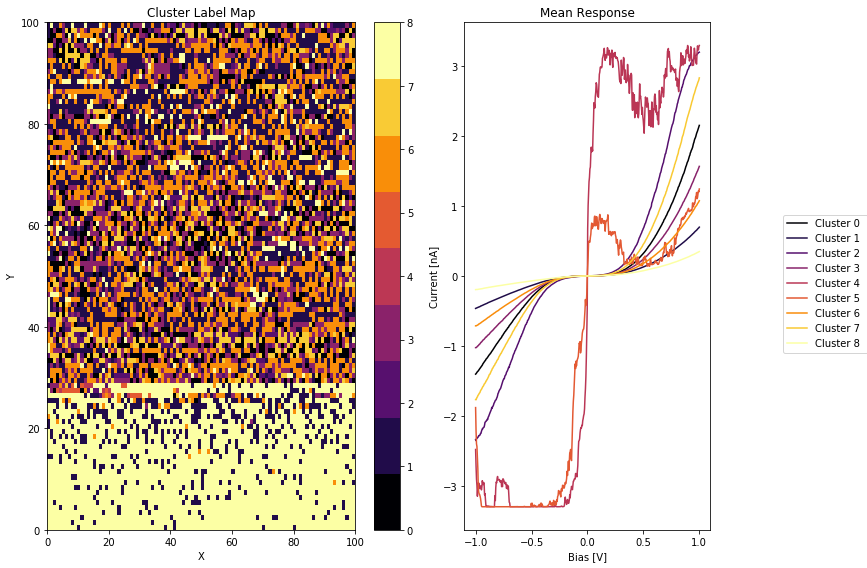

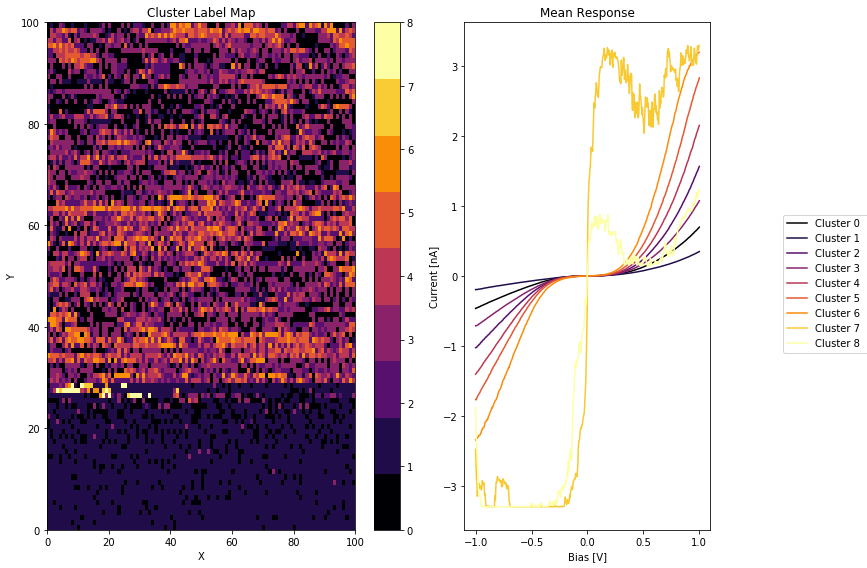

In [6]:
px.plot_utils.plot_cluster_results_together(np.reshape(results.labels_, (num_rows, num_cols)), 
                                            results.cluster_centers_, spec_val=volt_vec, cmap=plt.cm.inferno, 
                                            spec_label=x_label, resp_label=y_label);

px.plot_utils.plot_cluster_results_together(np.reshape(labels, (num_rows, num_cols)), 
                                            centroids, spec_val=volt_vec, cmap=plt.cm.inferno, 
                                            spec_label=x_label, resp_label=y_label);

## Preparing to write results

The two datasets we need to write back to the H5 file are the `centroids` and `labels` matrices. Both the `centroids` and `labels` matrices satisfy the condition to be elevated to the status of __`main`__ datasets. However, in order to be recognized as __`main`__ datasets, they need the four ancillary datasets to go along with them. Recall that the main datasets only need to store references to the ancillary datasets and that we do not need to store copies of the same ancillary datasets if multiple main datasets use them. 

Here, we will refer to the dataset on which K-means was performed as the __`source`__ dataset.

### Identifying the ancillary datasets:
* `centroids`: 
    * Spectroscopic Indices and Values: Since the `source` dataset and the `centroids` datasets both contain the same spectral information, the `centroids` dataset can simply reuse the ancillary spectroscopic datasets used by the `source` dataset.
    * Position Indices and Values: The `centroids` dataset has `k` instances while the `source` dataset has `P`, so we need to create a new position indicies and a new position values dataset for `centroids`
* `labels`: 
    * Spectroscopic Indices and Values: Unlike the `source` dataset that has spectra of length `S`, this dataset only has a single value (cluster index) at each location. Consequently, `labels` needs two new ancilary datasets
    * Position Indices and Values: Since both `source` and `labels` have the same number of positions and the positions mean the same quantities for both datasets, we can simply reuse the ancillary dataset from `source` for `labels`
    
## Preparing the missing ancillary arrays

In [7]:
labels_spec_mat = np.arange(1, dtype=np.uint32)
centroids_pos_mat = np.arange(num_clusters, dtype=np.uint32)

print('Spectroscopic Dataset for Labels', labels_spec_mat.shape)
print('Position Dataset for Centroids', centroids_pos_mat.shape)
print('Centroids',centroids.shape)
print('Labels', labels.shape)

Spectroscopic Dataset for Labels (1,)
Position Dataset for Centroids (9,)
Centroids (9, 500)
Labels (10000,)


## Reshape the matricies to the correct dimensions

1. Since `labels` is a main dataset, it needs to be two dimensional matrix of size `P x 1`
2. The `Spectroscopic` ancillary datasets for `labels` need to be of the form `dimension x points`. Since the spectroscopic axis of `labels` is only one deep, `labels` has only one spectroscopic dimension which itself has just one point. Thus the `Spectroscopic` matrix should be of size `1 x 1`
3. The `centroids` matrix is already of the form: `position x spectra`, so it does not need any reshaping
4. The `Position` ancillary datasets for `centroids` need to be of the form `points x dimensions` as well. In this case, `centroids` has `k` positions all in one dimension. Thus the matrix needs to be reshaped to `k x 1`

In [8]:
labels_spec_mat = np.atleast_2d(labels_spec_mat)
centroids_pos_mat = np.atleast_2d(centroids_pos_mat).T
labels_mat = np.uint32(labels.reshape([-1, 1]))

print('Spectroscopic Dataset for Labels', labels_spec_mat.shape)
print('Position Dataset for Centroids', centroids_pos_mat.shape)
print('Centroids',centroids.shape)
print('Labels', labels_mat.shape)

Spectroscopic Dataset for Labels (1, 1)
Position Dataset for Centroids (9, 1)
Centroids (9, 500)
Labels (10000, 1)


## Create the Main MicroDataset objects
Remember that it is important to either inherit or add the `quantity` and `units` attributes to each __main__ dataset

In [9]:
# The two main datasets
ds_label_mat = px.MicroDataset('Labels', labels_mat, dtype=np.uint32)
# Adding the mandatory attributes
ds_label_mat.attrs = {'quantity': 'Cluster ID', 'units': 'a. u.'}

ds_cluster_centroids = px.MicroDataset('Mean_Response', centroids, dtype=h5_main.dtype)
# Inhereting / copying the mandatory attributes
px.hdf_utils.copy_main_attributes(h5_main, ds_cluster_centroids)

## Create the ancillary MicroDataset objects

In [10]:
# Ancillary datasets
ds_cluster_inds = px.MicroDataset('Cluster_Indices', centroids_pos_mat, dtype=np.uint32)
ds_cluster_vals = px.MicroDataset('Cluster_Values', centroids_pos_mat, dtype=np.float32)
ds_label_inds = px.MicroDataset('Label_Spectroscopic_Indices', labels_spec_mat, dtype=np.uint32)
ds_label_vals = px.MicroDataset('Label_Spectroscopic_Values', labels_spec_mat, dtype=np.float32)

# Creating region references:
clust_slices = {'Cluster': (slice(None), slice(0, 1))}
ds_cluster_inds.attrs['labels'] = clust_slices
ds_cluster_inds.attrs['units'] = ['']
ds_cluster_vals.attrs['labels'] = clust_slices
ds_cluster_vals.attrs['units'] = ['']

## Create the group that will contain these datasets
We will be appending data to the existing h5 file and since HDF5 uses a tree structure to store information, we would need to specify where to add the sub-tree that we are building.

Recall that the name of the DataGroup provides information of the operation that has been performed on the `source` dataset. Therefore, we need to be careful about naming the group. 

It is also important to add relevant information about the operation. For example, the name of our operation is `Cluster` analogous to the `SkLearn` package organization. Thus, the name of the algorithm - `k-Means` needs to be written as an attribute of the group as well.

Occasionaly, the same operation may be performed multiple times on the same dataset with different parameters. In the case of K-means it may be the number of clusters. pycroscopy allows all these results to be stored instead of being overwritten by appending an index number to the end of the group name. Thus, one could have a tree that contains the following groups:
* Raw_Data-Cluster_000 <--- K-means with 9 clusters
* Raw_Data-Cluster_001 <--- Agglomerative clustering
* Raw_Data-Cluster_002 <--- K-means again with 4 clusters

Leaving a '_' at the end of the group name will instruct ioHDF5 to look for the last instance of the same operation being performed on the same dataset. The index will then be updated accordingly

In [11]:
source_dset_name = h5_main.name.split('/')[-1]
operation_name = 'Cluster'

subtree_root_path = h5_main.parent.name[1:]

cluster_grp = px.MicroDataGroup(source_dset_name + '-' + operation_name +'_', 
                             subtree_root_path)
print('New group to be created with name:', cluster_grp.name)
print('This group (subtree) will be appended to the H5 file under the group:', subtree_root_path)

# Making a tree structure by adding the MicroDataset objects as children of this group
cluster_grp.addChildren([ds_label_mat, ds_cluster_centroids, ds_cluster_inds, ds_cluster_vals, ds_label_inds,
                         ds_label_vals])

print('\nWill write the following tree:')
cluster_grp.showTree()

cluster_grp.attrs['num_clusters'] = num_clusters
cluster_grp.attrs['num_samples'] = h5_main.shape[0]
cluster_grp.attrs['cluster_algorithm'] = 'KMeans'

# Get the parameters of the KMeans object that was used and write them as attributes of the group
for parm in estimators.get_params().keys():
    cluster_grp.attrs[parm] = estimators.get_params()[parm]
    
print('\nWriting the following attrbutes to the group:')
for at_name in cluster_grp.attrs:
    print(at_name,':',cluster_grp.attrs[at_name])

New group to be created with name: Raw_Data-Cluster_
This group (subtree) will be appended to the H5 file under the group: Measurement_000/Channel_000

Will write the following tree:
Measurement_000/Channel_000Raw_Data-Cluster_/Labels
Measurement_000/Channel_000Raw_Data-Cluster_/Mean_Response
Measurement_000/Channel_000Raw_Data-Cluster_/Cluster_Indices
Measurement_000/Channel_000Raw_Data-Cluster_/Cluster_Values
Measurement_000/Channel_000Raw_Data-Cluster_/Label_Spectroscopic_Indices
Measurement_000/Channel_000Raw_Data-Cluster_/Label_Spectroscopic_Values

Writing the following attrbutes to the group:
n_clusters : 9
n_init : 10
tol : 0.0001
num_samples : 10000
num_clusters : 9
max_iter : 300
init : k-means++
precompute_distances : auto
algorithm : auto
verbose : 0
cluster_algorithm : KMeans
machine_id : mac109728.ornl.gov
random_state : None
timestamp : 2017_08_10-16_19_17
n_jobs : 1
copy_x : True


## Write to H5 and access the written objects

Once the tree is prepared (previous cell), ioHDF5 will handle all the file writing.

In [12]:
h5_clust_refs = hdf.writeData(cluster_grp)

h5_labels = px.hdf_utils.getH5DsetRefs(['Labels'], h5_clust_refs)[0]
h5_centroids = px.hdf_utils.getH5DsetRefs(['Mean_Response'], h5_clust_refs)[0]
h5_clust_inds = px.hdf_utils.getH5DsetRefs(['Cluster_Indices'], h5_clust_refs)[0]
h5_clust_vals = px.hdf_utils.getH5DsetRefs(['Cluster_Values'], h5_clust_refs)[0]
h5_label_inds = px.hdf_utils.getH5DsetRefs(['Label_Spectroscopic_Indices'], h5_clust_refs)[0]
h5_label_vals = px.hdf_utils.getH5DsetRefs(['Label_Spectroscopic_Values'], h5_clust_refs)[0]

## Look at the H5 file contents now 
Compare this tree with the one printed earlier. The new group and datasets should be apparent

In [13]:
px.hdf_utils.print_tree(h5_file)

/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Raw_Data-Cluster_000
Measurement_000/Channel_000/Raw_Data-Cluster_000/Cluster_Indices
Measurement_000/Channel_000/Raw_Data-Cluster_000/Cluster_Values
Measurement_000/Channel_000/Raw_Data-Cluster_000/Label_Spectroscopic_Indices
Measurement_000/Channel_000/Raw_Data-Cluster_000/Label_Spectroscopic_Values
Measurement_000/Channel_000/Raw_Data-Cluster_000/Labels
Measurement_000/Channel_000/Raw_Data-Cluster_000/Mean_Response
Measurement_000/Channel_000/Spectroscopic_Indices
Measurement_000/Channel_000/Spectroscopic_Values


## Make `centroids` and `labels` -> `main` datasets
We elevate the status of these datasets by linking them to the four ancillary datasets. This part is also made rather easy by a few pycroscopy functions. 

In [14]:
# we already got the reference to the spectroscopic values in the first few cells
h5_spec_inds = px.hdf_utils.getAuxData(h5_main, 'Spectroscopic_Indices')[0]

px.hdf_utils.checkAndLinkAncillary(h5_labels,
                      ['Position_Indices', 'Position_Values'],
                      h5_main=h5_main)
px.hdf_utils.checkAndLinkAncillary(h5_labels,
                      ['Spectroscopic_Indices', 'Spectroscopic_Values'],
                      anc_refs=[h5_label_inds, h5_label_vals])

px.hdf_utils.checkAndLinkAncillary(h5_centroids,
                      ['Spectroscopic_Indices', 'Spectroscopic_Values'],
                      anc_refs=[h5_spec_inds, h5_spec_vals])

px.hdf_utils.checkAndLinkAncillary(h5_centroids,
                      ['Position_Indices', 'Position_Values'],
                      anc_refs=[h5_clust_inds, h5_clust_vals])

## Why bother with all this?
* Though long, this simple file writing procedure needs to be written once for a given data analysis / processing tool
* The general nature of this Clustering algorithm facilitates the application to several other datasets regardless of their origin 
* Once the data is written in the pycroscopy format, it is possible to apply other data analytics operations to the datasets with a single line
* Generalized versions of visualization algorithms can be written to visualize clustering results quickly.
    
Here is an example of very quick visualization with effectively just a single parameter - the group containing clustering results. The ancillary datasets linked to `labels` and `centroids` instructed the code about the spatial and spectroscopic dimensionality and enabled it to automatically render the plots below

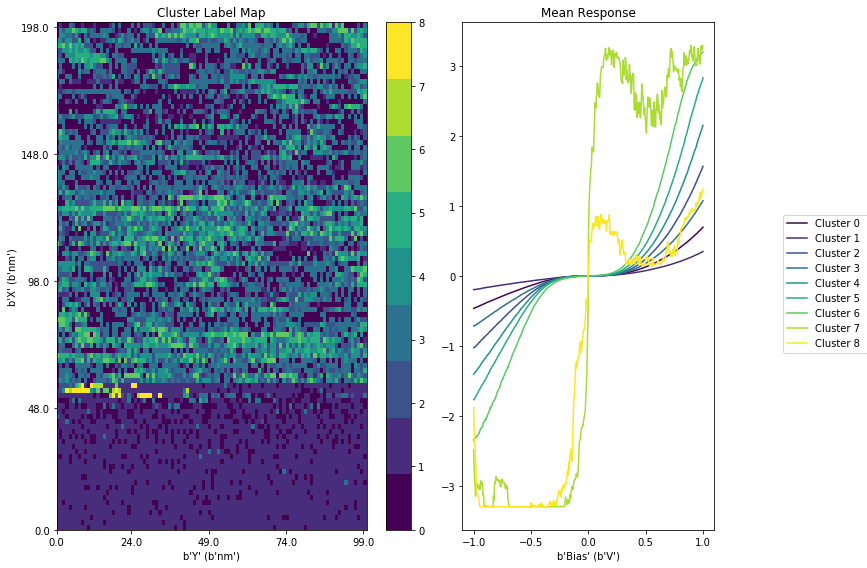

In [15]:
px.plot_utils.plot_cluster_h5_group(h5_labels.parent, '');

## Cleanup
Deletes the temporary files created in the example

In [16]:
os.remove(data_file_path)
hdf.close()
os.remove(h5_path)